In [1]:
import numpy as np
import pandas as pd
import time  #统计运行时间用
import copy  #深拷贝的时候用
import _pickle as cPickle
import gc #释放内存使用
from tqdm import tqdm,tqdm_notebook  #Tqdm 是一个快速，可扩展的Python进度条
import datetime #处理时间数据
import os
 
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score,mean_squared_error,roc_auc_score,log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
 
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator, FormatStrFormatter
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings ( 'ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',100)
pd.set_option('max_colwidth',100)


# 数据预处理

In [2]:
data=pd.read_csv('total_t.csv')
#选出'Source Country'是'China'且Target Country'是'United States'
data=data.drop(['Event ID','Story ID'],axis=1)
data=data[data['Source Country']!='India']
data=data[data['Target Country']!='India']



In [3]:
# one-hot编码，由于原数据部分属性类别过多，且很多类的个数很少，处理后矩阵维数过大，这里只选取数量最多的几类
for col in ['Source Name','Event Text','Target Name','Publisher','Country']:
    index=list(pd.DataFrame(data[col].value_counts()).iloc[:10].index)
    data=data[data[col].isin(index)]
for col in ['Source Country','Target Country','Source Name', 'Event Text', 'Target Name', 'Publisher', 'Country']:   
    one_hot = pd.get_dummies(pd.DataFrame(data[col]))
    # 将 one-hot 编码后的结果与原 DataFrame 进行合并
    data = pd.concat([data, one_hot], axis=1)
    # 删除原始的 col 列
    data = data.drop(col, axis=1)

data['Event Date']=data['Event Date'].astype('datetime64[D]')
data=data.sort_values(by='Event Date')
data=data.reset_index(drop=True)


In [4]:
data

,Event Date,CAMEO Code,Intensity,Sentence Number,Latitude,Longitude,Source Country_China,Source Country_United States,Target Country_China,Target Country_United States,Source Name_China,Source Name_Citizen (China),Source Name_Foreign Affairs (China),Source Name_Joseph Robinette Biden,Source Name_Media Personnel (China),Source Name_Other Authorities / Officials (China),Source Name_Police (China),Source Name_United States,Source Name_Wang Yi,Source Name_Xi Jinping,Event Text_Accuse,"Event Text_Arrest, detain, or charge with legal action",Event Text_Consult,Event Text_Criticize or denounce,Event Text_Engage in negotiation,Event Text_Express intent to meet or negotiate,Event Text_Host a visit,Event Text_Make a visit,Event Text_Make an appeal or request,Event Text_Make statement,Target Name_Cabinet / Council of Ministers / Advisors (United States),Target Name_China,Target Name_Citizen (China),Target Name_Criminal (China),Target Name_Government (China),Target Name_Joseph Robinette Biden,Target Name_Other Authorities / Officials (China),Target Name_United States,Target Name_Wang Yi,Target Name_Xi Jinping,Publisher_Agence France-Presse,Publisher_China Daily,Publisher_FARS News Agency,Publisher_Hindustan Times,Publisher_Kyodo News,Publisher_Reuters News,Publisher_South China Morning Post,Publisher_Straits Times,Publisher_Unknown,Publisher_Xinhua News Agency,Country_China,Country_Hong Kong,Country_Iran,Country_Italy,Country_Japan,Country_Russian Federation,Country_Taiwan,Country_United Kingdom,Country_United States,Country_Vietnam
0,2020-04-30,173,-5.0,1,48.0000,128.000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2020-04-30,10,0.0,2,30.5833,114.267,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2020-05-01,111,-2.0,5,28.0000,112.000,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2020-05-01,173,-5.0,3,36.0823,101.713,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
4,2020-05-01,173,-5.0,1,25.0389,102.718,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8734,2022-03-21,10,0.0,1,39.9075,116.397,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
8735,2022-03-21,40,1.0,3,39.9075,116.397,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8736,2022-03-21,40,1.0,3,39.9075,116.397,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8737,2022-03-21,46,7.0,1,29.7080,118.332,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


# LASSO

## 特征提取

In [5]:
label='Intensity'
feas=data.columns.tolist()
feas.remove(label)
feas.remove('Event Date')
print('特征数量:',len(feas))

X_train=data.drop([label,'Event Date'],axis=1)[:3285]
y_train=data[label][:3285]
X_test=data.drop([label,'Event Date'],axis=1)[3285:]
y_test=data[label][3285:]
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)

scaler = StandardScaler()  # 标准化 z = (x - u) / s
X_train_std = pd.DataFrame(scaler.fit_transform(X_train))
X_train_std.columns=X_train.columns

特征数量: 58
X_train: (3285, 58)
y_train: (3285,)


In [6]:

def select_feas_lasso(trainX,trainy,metric_name='rmse',kfNum=2):

    s=time.time()
    print('\n********lasso_select_feas...start')
    print('评估指标：',metric_name)
    print('交叉验证轮数：',kfNum)
    print('训练集形状：',trainX.shape,type(trainX))
 
    #对于#0.001-100，使用logspace
    lasso_alphas1 = np.logspace(start=-3, stop=2, num=50, base=10) #0.001-100
    #对于比较大的lambda，使用整数步长
    lasso_alphas2 = np.arange(start=100,stop=1000,step=20)
    lasso_alphas= np.concatenate((lasso_alphas1, lasso_alphas2))
    print('待计算正则化参数数量：',len(lasso_alphas))
    print('待计算正则化参数最小值：',np.min(lasso_alphas))   
    print('待计算正则化参数最大值：',np.max(lasso_alphas))   
 
    valid_scores = [] #存储每个正则化参数下的评估指标均值如rmse
    keep_var_nums = [] #存储每个正则化参数下保留的特征数量均值
    valid_scores_std = [] #标准差
    keep_var_nums_std = []  #标准差
    for  alpha in tqdm(lasso_alphas):  
        clf = Lasso(max_iter=1000,random_state=2020,alpha=alpha)
        kf=KFold(n_splits=kfNum, shuffle=True, random_state=2020)
        valid_score=[]  #存储每轮交叉验证的评估指标如rmse
        keep_var_num=[] #存储每轮交叉验证保留特征数量
        for i,(trn_index,val_index) in enumerate(kf.split(trainX,trainy)):  #i从0开始，可以显示第几轮了
            trn_df=trainX.iloc[trn_index]
            val_df=trainX.iloc[val_index]            
            trn_y=trainy.iloc[trn_index]
            val_y=trainy.iloc[val_index]
 
            clf.fit(X=trn_df, y=trn_y)
            #利用本轮模型预测本轮验证集  
            valid_pred=clf.predict(val_df)
            #-------计算本轮评估指标--------#
            if metric_name == 'rmse':
                valid_score_this=mean_squared_error(val_y,valid_pred,squared=True)
            elif metric_name == 'logloss':
                valid_score_this=log_loss(y_true=val_y,y_pred=valid_pred)
            elif metric_name == 'auc':
                valid_score_this=roc_auc_score(y_true=val_y,y_score=valid_pred)
            else:
                print('没这评估指标')
                return
        
            valid_score.append(valid_score_this)  #列表append后直接替换原对象，所以不用再赋值
            # print(valid_score)
            keep_var_num=sum(clf.coef_ != 0) #统计系数不为0的特征数量（不含截距）
            # print(keep_var_num)
        valid_scores.append(np.mean(valid_score)) #metric取均值，存入
        keep_var_nums.append(np.mean(keep_var_num)) #保留特征数量取均值，存入
        valid_scores_std.append(np.std(valid_score)) #metric取标准差，存入
        keep_var_nums_std.append(np.std(keep_var_num)) #保留特征数量取均值取标准差，存入
          
    res={'lasso_alphas':lasso_alphas,
         'valid_scores':valid_scores,'valid_scores_std':valid_scores_std,
         'keep_var_nums':keep_var_nums,'keep_var_nums_std':keep_var_nums_std}
    
    return res
 

res=select_feas_lasso(trainX=X_train_std,trainy=y_train,metric_name='rmse',kfNum=2)


********lasso_select_feas...start
评估指标： rmse
交叉验证轮数： 2
训练集形状： (3285, 58) <class 'pandas.core.frame.DataFrame'>
待计算正则化参数数量： 95
待计算正则化参数最小值： 0.001
待计算正则化参数最大值： 980.0


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:01<00:00, 51.21it/s]


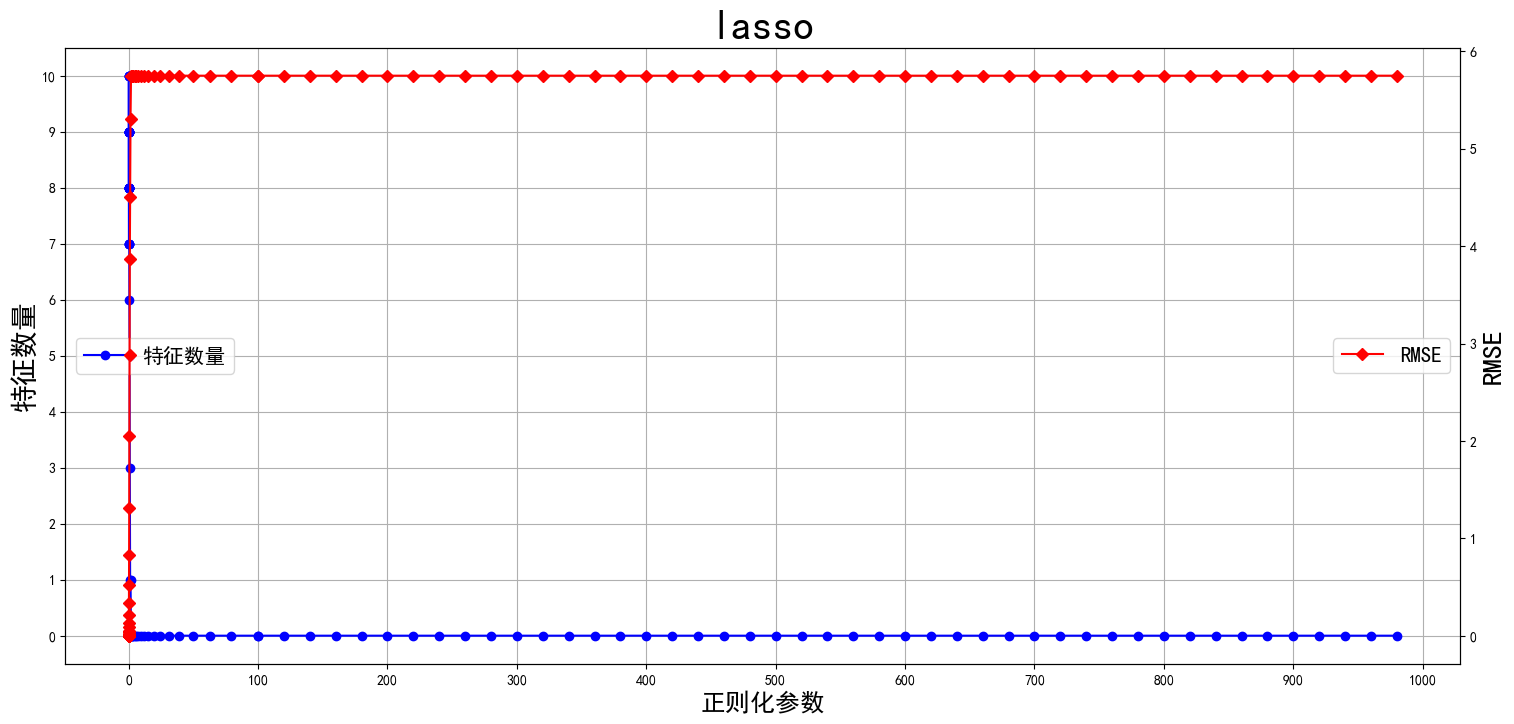

In [7]:
lasso_alphas=res['lasso_alphas']
valid_scores=res['valid_scores']
keep_var_nums=res['keep_var_nums']
mertic_name='RMSE'
 
fig  = plt.figure(figsize=(18, 8))
ax1=fig.add_subplot(111)
ax1.plot(lasso_alphas,keep_var_nums, "b-o",label='特征数量') #画出折线并且添加实心圆点
ax1.set_ylabel('特征数量',fontsize=20)
ax1.grid(True) #显示网格线
xmajorLocator  = MultipleLocator(100)  # x轴刻度间隔 100
ymajorLocator  = MultipleLocator(1)    # y轴刻度间隔 1
ax1.yaxis.set_major_locator(ymajorLocator) 
ax1.xaxis.set_major_locator(xmajorLocator) 
plt.xlabel('正则化参数',fontsize=18) #添加x轴名称
 
ax2 = ax1.twinx()
ax2.plot(lasso_alphas,valid_scores, "r-D",label=mertic_name)  #画出折线并且添加实心菱形
ax2.set_ylabel(mertic_name,fontsize=20)

ax1.legend(loc='center left',fontsize=15) #添加图例
ax2.legend(loc='center right',fontsize=15)
 
plt.title('lasso',fontsize=30) 
plt.show()

选择alpha=0,04

In [8]:
best_clf = Lasso(max_iter=1000,random_state=0,alpha=0.01)
best_clf.fit(X=X_train_std, y=y_train)
coef=pd.Series(best_clf.coef_,index=best_clf.feature_names_in_)
coef.sort_values(ascending=False)

Event Text_Engage in negotiation                                         0.813025
Event Text_Express intent to meet or negotiate                           0.601872
Event Text_Make an appeal or request                                     0.410765
Event Text_Host a visit                                                  0.373536
Event Text_Make a visit                                                  0.191390
Target Name_China                                                       -0.000000
Publisher_Kyodo News                                                    -0.000000
Target Name_Other Authorities / Officials (China)                        0.000000
Target Name_United States                                                0.000000
Target Name_Wang Yi                                                      0.000000
Target Name_Xi Jinping                                                   0.000000
Publisher_Agence France-Presse                                          -0.000000
Publisher_China 


选取五个特征

## 预测

In [9]:
data


,Event Date,CAMEO Code,Intensity,Sentence Number,Latitude,Longitude,Source Country_China,Source Country_United States,Target Country_China,Target Country_United States,Source Name_China,Source Name_Citizen (China),Source Name_Foreign Affairs (China),Source Name_Joseph Robinette Biden,Source Name_Media Personnel (China),Source Name_Other Authorities / Officials (China),Source Name_Police (China),Source Name_United States,Source Name_Wang Yi,Source Name_Xi Jinping,Event Text_Accuse,"Event Text_Arrest, detain, or charge with legal action",Event Text_Consult,Event Text_Criticize or denounce,Event Text_Engage in negotiation,Event Text_Express intent to meet or negotiate,Event Text_Host a visit,Event Text_Make a visit,Event Text_Make an appeal or request,Event Text_Make statement,Target Name_Cabinet / Council of Ministers / Advisors (United States),Target Name_China,Target Name_Citizen (China),Target Name_Criminal (China),Target Name_Government (China),Target Name_Joseph Robinette Biden,Target Name_Other Authorities / Officials (China),Target Name_United States,Target Name_Wang Yi,Target Name_Xi Jinping,Publisher_Agence France-Presse,Publisher_China Daily,Publisher_FARS News Agency,Publisher_Hindustan Times,Publisher_Kyodo News,Publisher_Reuters News,Publisher_South China Morning Post,Publisher_Straits Times,Publisher_Unknown,Publisher_Xinhua News Agency,Country_China,Country_Hong Kong,Country_Iran,Country_Italy,Country_Japan,Country_Russian Federation,Country_Taiwan,Country_United Kingdom,Country_United States,Country_Vietnam
0,2020-04-30,173,-5.0,1,48.0000,128.000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2020-04-30,10,0.0,2,30.5833,114.267,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2020-05-01,111,-2.0,5,28.0000,112.000,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2020-05-01,173,-5.0,3,36.0823,101.713,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
4,2020-05-01,173,-5.0,1,25.0389,102.718,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8734,2022-03-21,10,0.0,1,39.9075,116.397,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
8735,2022-03-21,40,1.0,3,39.9075,116.397,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8736,2022-03-21,40,1.0,3,39.9075,116.397,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8737,2022-03-21,46,7.0,1,29.7080,118.332,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [10]:
#只选用上述五个特征
data1=data[['Event Date','Event Text_Engage in negotiation','Event Text_Express intent to meet or negotiate','Event Text_Make statement','Event Text_Make an appeal or request','CAMEO Code','Intensity']]
data1['Event Date']=data1['Event Date'].astype('datetime64[D]')
data1=data1.sort_values(by='Event Date')
data1['time']=data1['Event Date']-min(data1['Event Date'])
data1['time'] =data1['time'].astype('timedelta64[D]').astype(float)
data1=data1.drop('Event Date',axis=1)
data1=data1.reset_index(drop=True)


In [11]:
label='Intensity'
X_train=data1.drop([label,'time'],axis=1)[:3285]
y_train=data1[label][:3285]
X_test=data1.drop([label,'time'],axis=1)[3285:]
y_test=data1[label][3285:]
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
scaler = StandardScaler()  # 标准化 z = (x - u) / s
X_train_std = pd.DataFrame(scaler.fit_transform(X_train))
X_train_std.columns=X_train.columns

scaler = StandardScaler()  # 标准化 z = (x - u) / s
X_test_std = pd.DataFrame(scaler.fit_transform(X_test))
X_test_std.columns=X_test.columns

X_train: (3285, 5)
y_train: (3285,)


In [12]:
best_clf = Lasso(max_iter=1000,random_state=0,alpha=0.04)
best_clf.fit(X=X_train_std, y=y_train)

Lasso(alpha=0.04, random_state=0)

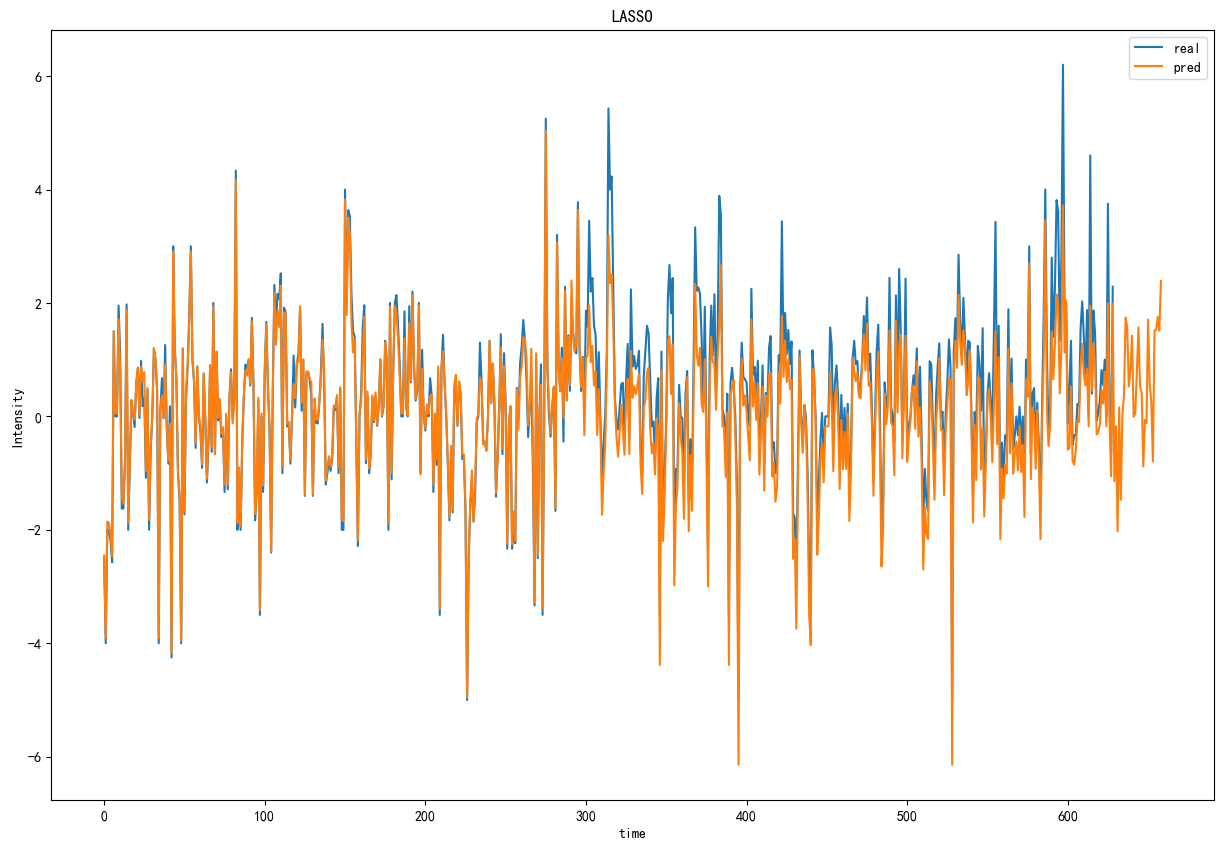

In [13]:
data1['y_pred']=[0]*len(data1)
data1['y_pred'][:3285]=best_clf.predict(X_train_std)
data1['y_pred'][3285:]=best_clf.predict(X_test_std)
y=[]
y_pred=[]
for i,temp in data1.groupby('time'):
    y.append(temp['Intensity'].mean())
    y_pred.append(temp['y_pred'].mean())
res=pd.DataFrame([y,y_pred],index=['real','pred']).T
plt.figure(figsize=(15,10))
plt.title('LASSO')
plt.xlabel('time')
plt.ylabel('Intensity')
plt.plot(res[:-30]['real'],label='real')
plt.plot(res['pred'],label='pred')
plt.legend()
plt.show()

# Arima

## 数据处理

In [14]:
y=[]
for i,temp in data.groupby('Event Date'):
    y.append([i,temp['Intensity'].mean()])
y=pd.DataFrame(y,columns=['Date','Intensity'])
y=y.set_index('Date')

## 平稳性检验

In [15]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
sm.tsa.stattools.adfuller(y['Intensity'])

(-13.255334383879456,
 8.610724893876722e-25,
 1,
 657,
 {'1%': -3.440342440623255,
  '5%': -2.8659491890487026,
  '10%': -2.569118060113657},
 2196.4416601484004)

-14.636432840207643 比 -3.4401039634870623小，说明数据是平稳的

## 白噪声检验

In [16]:
acorr_ljungbox(y['Intensity'], lags = [6, 12],boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
6,104.867717,2.415570e-20,104.312392,3.155610e-20
12,120.177807,5.695773e-20,119.330463,8.403417e-20


显著水平（α = 0.05 \alpha=0.05α=0.05）,所以拒绝序列为纯随机序列的原假设，认为该序列为非白噪声序列


(<AxesSubplot: title={'center': 'A Given Training Series'}, xlabel='Date'>,
 <AxesSubplot: title={'center': 'Autocorrelation'}>,
 <AxesSubplot: title={'center': 'Partial Autocorrelation'}>)

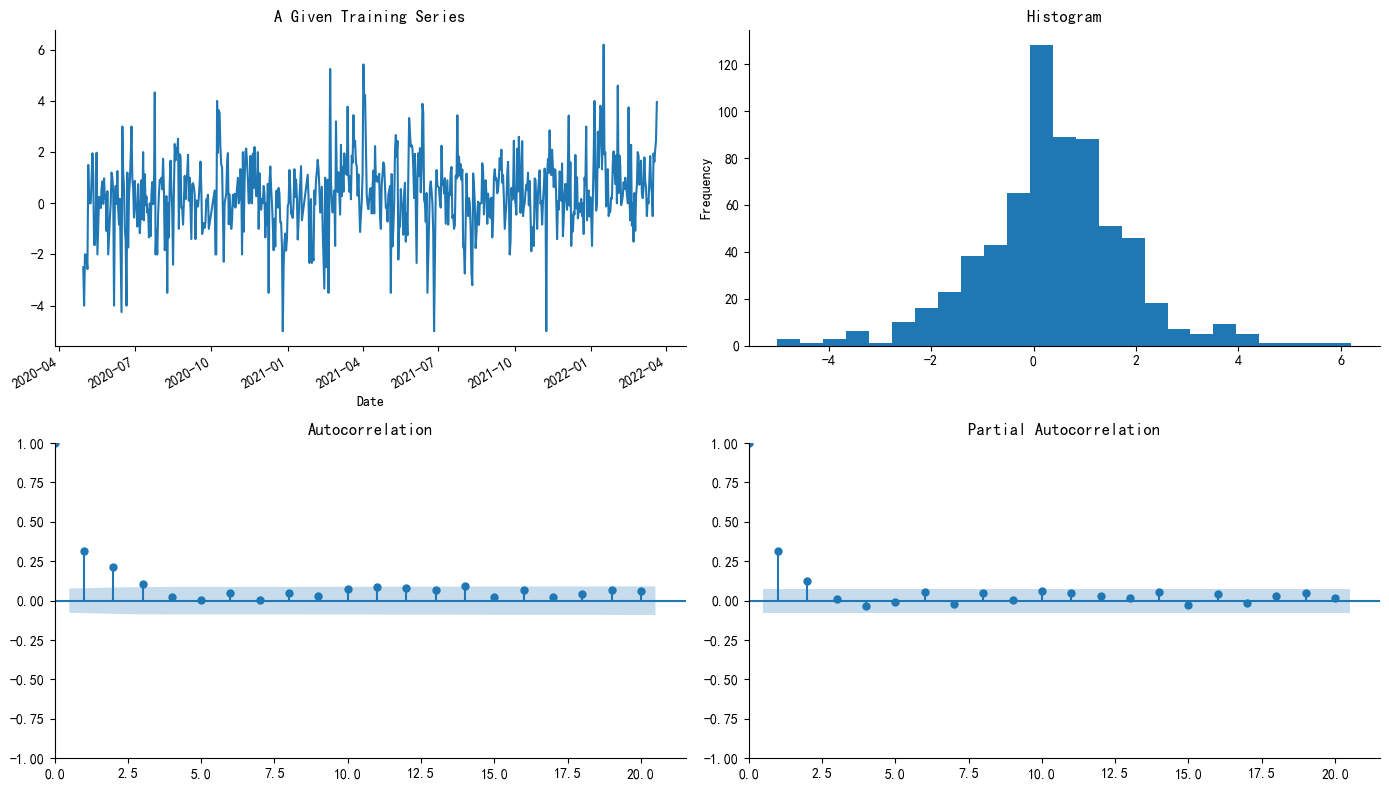

In [17]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax
tsplot(y['Intensity'], title='A Given Training Series', lags=20)

## 选择模型参数

In [18]:
import itertools

p_min = 0
q_min = 0
p_max = 7
q_max = 7

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,q in itertools.product(range(p_min,p_max+1),
                               
                               range(q_min,q_max+1)):
    if p==0  and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(y['Intensity'], order=(p, 1, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)


C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\A

C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\A

C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


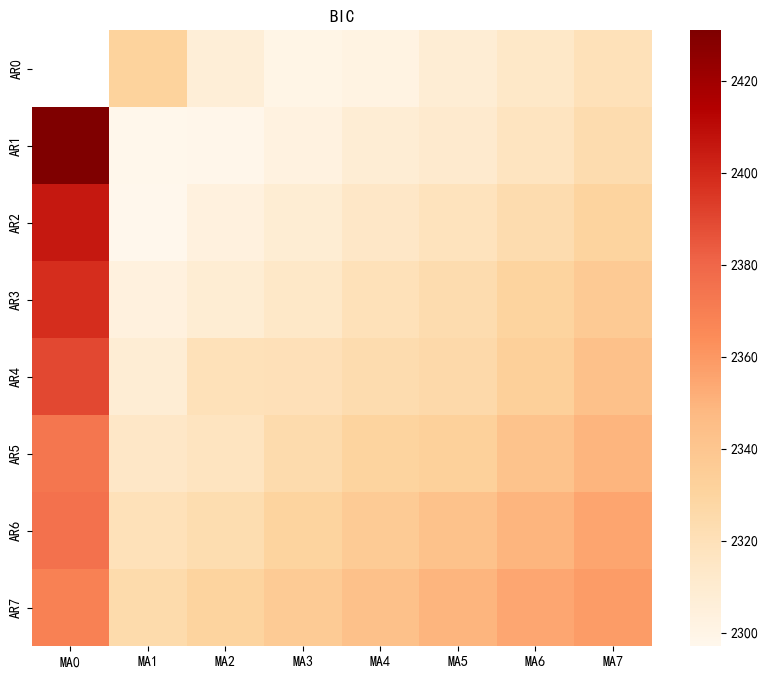

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 cmap='OrRd'
             
                 )
ax.set_title('BIC')
plt.show()

选择p=1,q=0

## 模型预测

C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\86152\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


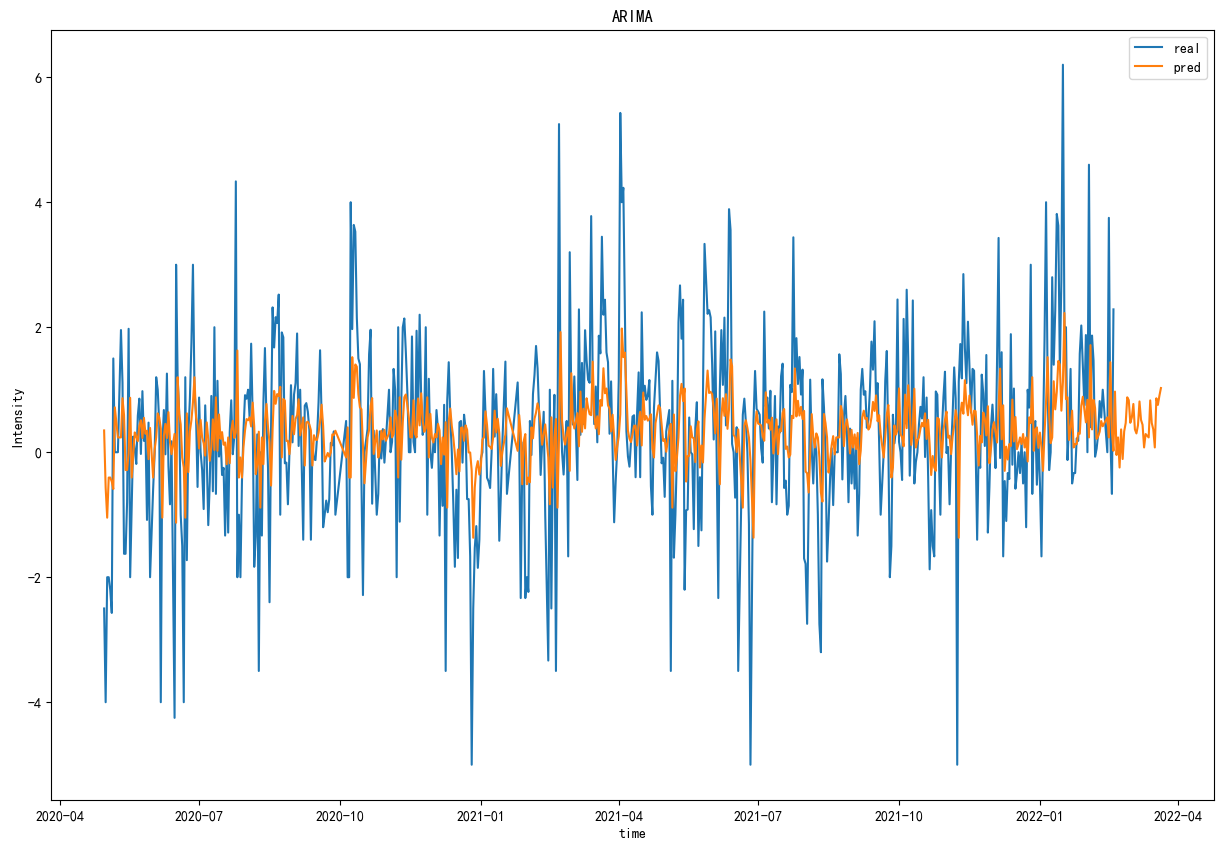

In [20]:
arima200 = sm.tsa.arima.ARIMA(y['Intensity'], order=(1,0,0))
model_results = arima200.fit()
y['pred']=model_results.predict('2020-4-30','2022-03-21')
plt.figure(figsize=(15,10))
plt.xlabel('time')
plt.ylabel('Intensity')
plt.title('ARIMA')
plt.plot(y[:-30]['Intensity'],label='real')
plt.plot(y['pred'],label='pred')
plt.legend()
plt.show()